<a href="https://colab.research.google.com/github/ZzzTheGamer/XAI/blob/Assignment5_Explainable_Deep_Learning/Explainable_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Below is my experimental design before testing begins ▶

### **Hypothesis**

**H0:** For images labeled as "airplane" in the Pascal VOC 2012 dataset, the ResNet-50 model does not exhibit a statistically significant difference in its Grad-CAM activation between the foreground ( the segmented airplane region) and the background region during classification.

**H1:** For images labeled as "airplane" in the Pascal VOC 2012 dataset, the ResNet-50 model exhibits a statistically significant difference in its Grad-CAM activation between the foreground and the background region during classification. Specifically, it learns the concept "airplane" but not the concept "background".

### **Study Design**

1. **Define concepts**

- **Target class:** "aeroplane" as defined in the Pascal VOC 2012 dataset.

- **Concepts to test:**

  - **1:** "Foreground" – the segmented region corresponding to the airplane.

  - **2:** "Background" – the remainder of the image outside the airplane segmentation.

- **Rationale behind the design:** If ResNet-50 has truly learned to recognize airplanes, its Grad-CAM heatmaps should display more pronounced activation in the airplane region compared to the background. This would confirm that the model's decision-making is driven by the object's defining features rather than by contextual artifacts.

2. **Dataset preparation**

- **Annotations:**
  - Use existing segmentation masks provided for the airplane region as the foreground.
  - Define the background as all image regions outside the segmented airplane.

3. **Grad-CAM implementation**

- **Model:** ResNet-50 pretrained on ImageNet.
- **Grad-CAM setup:**
  - Extract Grad-CAM heatmaps for the target class for each image.
  - Use the final convolutional layer as the source for the activation maps.

4. **Quantify activation intensity**

- **Metric:** Compute the mean Grad-CAM activation value within each annotated region (foreground vs background).
- **Calculation:**
  - For each image, compute:
    - **MeanActivation<sub>foreground</sub>** = (1 / *N*<sub>pixels_in_foreground</sub>) × ∑ (Grad-CAM values in the airplane region)
    - **MeanActivation<sub>background</sub>** = (1 / *N*<sub>pixels_in_background</sub>) × ∑ (Grad-CAM values in the background)
    - **Normalization:** Normalize activation values to mitigate variability in absolute heatmap intensities.

5. **Statistical Analysis**

- **Paired t-test:** Compare **MeanActivation<sub>foreground</sub>** vs **MeanActivation<sub>background</sub>** across all selected images.

- **Cohen’s d:** Compute Cohen’s d to quantify the magnitude of the difference between the two regions.

- **Null hypothesis rejection:** If *p* < 0.05 and **MeanActivation<sub>foreground</sub>** > **MeanActivation<sub>background</sub>**, reject H0 in favor of H1.

6. **Interpretability check**

- Visualize Grad-CAM heatmaps for select images where the model shows a pronounced difference in activation between the foreground and background to qualitatively assess the findings.

- Investigate potential biases such as segmentation inaccuracies and background artifacts that might influence the results.

### **Key Challenges/Limitations**

- Segmentation masks in the original dataset may not accurately or consistently delineate airplane regions from the background.
- Grad-CAM heatmap might blur into adjacent regions, potentially confounding foreground and background measurements.
- It's difficult to manage differences in airplane sizes, positions, and the complexity of backgrounds across images.

# Next comes the part that tests the hypothesis ▶

In [ ]:
# Download dataset
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
# Decompressing dataset
!tar -xvf VOCtrainval_11-May-2012.tar

In [1]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **Step 1：Initialization** ( images, Grad-CAM class, preprocessing image function )

* Load images

In [3]:
# Define directories for VOC 2012 images and segmentation masks (You can download it from the original code block)
# Here, JPEGImages contains the raw RGB images.
# SegmentationClass contains the corresponding pixel-level segmentation masks.
image_dir = './VOCdevkit/VOC2012/JPEGImages/'
mask_dir  = './VOCdevkit/VOC2012/SegmentationClass/'

# List image files (they have .jpg or .png extensions)
image_files = [fname for fname in os.listdir(image_dir) if fname.lower().endswith(('.jpg', '.png'))] # refined chatgpt-4o on 2/5/2025 at 6:02pm
image_files = sorted(image_files)
print(f"total number of {len(image_files)} images found")

total number of 17125 images found


* Define GradCAM class

In [4]:
class GradCAM:
    def __init__(self, model, target_layer):
        """
        Initialize the GradCAM class, store the model and target layer, and register forward and backward hooks.
        """
        # Store the model
        self.model = model
        # Store the target layer
        self.target_layer = target_layer
        # Store gradients captured during backpropagation
        self.gradients = None
        # Store activations captured during forward pass
        self.activations = None
        # Store hook
        self.hook_handles = []
        # Register the hooks
        self._register_hooks()

    def _register_hooks(self):
        """
        Register forward and backward hooks on the target layer to capture activations and gradients.
        """
        # Forward hook: capture the activations of the target layer
        self.hook_handles.append(
            self.target_layer.register_forward_hook(self.forward_hook)
        )
        # Backward hook: capture the gradients of the target layer
        self.hook_handles.append(
            self.target_layer.register_backward_hook(self.backward_hook)
        )

    def forward_hook(self, module, input, output):
        """
        Forward hook function: capture the output activations during the forward pass.
        """
        self.activations = output.detach()

    def backward_hook(self, module, grad_in, grad_out):
        """
        Backward hook function: capture the gradients during the backward pass.
        """
        self.gradients = grad_out[0].detach()

    def generate(self, input_tensor, target_class):
        """
        Generate the Grad-CAM heatmap:
        1. Perform forward pass to obtain the output.
        2. Compute gradients for the target class.
        3. Apply global average pooling on the gradients to obtain weights.
        4. Compute the weighted sum of activations, apply ReLU, upsample, and normalize to [0,1].
        """
        # Clear existing gradients
        self.model.zero_grad()
        # Forward pass
        output = self.model(input_tensor)

        # Extract the logit score for the target class
        score = output[0, target_class]

        # Backpropagate to compute gradients
        score.backward(retain_graph=True)

        # Perform global average pooling on the gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)

        # Compute the weighted sum of the activations: multiply weights with activations and sum across channels
        grad_cam_map = (weights * self.activations).sum(dim=1, keepdim=True)
        # Apply ReLU to keep only positive values
        grad_cam_map = F.relu(grad_cam_map)
        # Upsample the grad-cam map to the input image size
        grad_cam_map = F.interpolate(grad_cam_map, size=input_tensor.shape[2:], mode='bilinear', align_corners=False) # use chatgpt-4o on 2/5/2025 at 7:11pm

        # Normalize the heatmap to the range [0, 1]
        heatmap = grad_cam_map.squeeze().cpu().numpy()
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

        return heatmap

    def remove_hooks(self):
        """
        Remove all registered hooks to prevent memory leaks.
        """
        for handle in self.hook_handles:
            handle.remove()


* Define preprocessing function

In [5]:
# Preprocessing image function
# Preprocess the original image
transform = transforms.Compose([
    # Resize the image to 224x224 pixels
    transforms.Resize((224, 224)),
    # Convert the image to a tensor and scale pixel values to [0, 1]
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
               std =[0.229, 0.224, 0.225])
])

# Preprocess the segmentation mask image
mask_transform = transforms.Compose([
    # Resize the mask to have a short edge of 256 pixels using nearest neighbor interpolation
    transforms.Resize(256, interpolation=transforms.InterpolationMode.NEAREST),# use chatgpt-4o on 2/5/2025 at 7:25pm
    # Center-crop a 224x224 region from the resized mask
    transforms.Resize((224, 224))
])

### **Step 2**: Load pretrained ResNet-50 model

In [6]:
# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
model.to(device)
model.eval()

# For ResNet-50, select the target layer as the last convolutional layer
target_layer = model.layer4[-1].conv3
# Create an instance of GradCAM with the model and target layer
grad_cam = GradCAM(model, target_layer)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### **Step 3**: Iterate through images and compute Grad-CAM heatmaps

In [7]:
# Target class index(airplane)
target_class = 404

# Label index for airplane in VOC segmentation annotations
voc_airPlane_label = 1

# Lists to store the average activation values for the foreground and background
foreground_activation_means = []
background_activation_means = []

# List to store some visualization examples for later display
visualization_examples = []

# Loop through all images
for fname in image_files:
    img_path = os.path.join(image_dir, fname)
    mask_path = os.path.join(mask_dir, os.path.splitext(fname)[0] + '.png') # use chatgpt-4o on 2/5/2025 at 7:33pm

     # Check if the corresponding segmentation mask exists
    if not os.path.exists(mask_path):
        continue

    # Load the image and convert it to RGB format
    original_img = Image.open(img_path).convert('RGB')
    # Load the segmentation mask
    mask_img = Image.open(mask_path)

    # Resize the mask to the same size as the model input
    mask_img_resized = mask_transform(mask_img)
    mask_np = np.array(mask_img_resized)

    # Check whether the image contain a sufficient airplane region( here we use threshold 0.2)
    if np.sum(mask_np == voc_airPlane_label) / mask_np.size < 0.2:
      continue

    # Create a binary foreground mask: values will be 1 for foreground and 0 for background
    foreground_mask = (mask_np == voc_airPlane_label).astype(np.uint8)

    # Preprocess the image
    input_tensor = transform(original_img).unsqueeze(0).to(device)

    # Generate the Grad-CAM heatmap
    heatmap = grad_cam.generate(input_tensor, target_class)

    # Compute the average activation values within the foreground and background regions
    foreground_vals = heatmap[foreground_mask == 1]
    background_vals = heatmap[foreground_mask == 0]

    # Skip this image if either the foreground or background region is empty
    if foreground_vals.size == 0 or background_vals.size == 0:
        continue

    # Calculate the mean activation values for the foreground and background regions
    mean_foreground = np.mean(foreground_vals)
    mean_background = np.mean(background_vals)

    # Append the computed mean activation values to their respective lists
    foreground_activation_means.append(mean_foreground)
    background_activation_means.append(mean_background)

    # Save some examples
    visualization_examples.append({
        'filename': fname,
        'original': original_img,
        'heatmap': heatmap,
        'mask': foreground_mask
    })

print(f"Totally {len(foreground_activation_means)} images processed that contain airplane segmentation annotations")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Totally 32 images processed that contain airplane segmentation annotations


### **Step 4**: Perform paired t-test on foreground vs. background activations

In [8]:
# Convert the lists of foreground and background activation means to NumPy arrays
foreground_vals = np.array(foreground_activation_means)
background_vals = np.array(background_activation_means)

# Perform a paired t-test to compare the activation values between the foreground and background
t_stat, p_value = ttest_rel(foreground_vals, background_vals, nan_policy='omit')

# Calculate the differences between foreground and background activation values
differences = foreground_vals - background_vals
# Compute the mean of the differences
mean_diff = np.nanmean(differences)
# Compute the standard deviation of the differences (with degrees of freedom correction, ddof=1)
std_diff = np.nanstd(differences, ddof=1) # use chatgpt-4o on 2/5/2025 at 8:30pm
# Calculate Cohen's d effect size
cohens_d = mean_diff / std_diff

print("paired t-test result：")
print(f"t = {t_stat:.3f}, p = {p_value:.3f}")
print(f"Cohen's d = {cohens_d:.3f}")

paired t-test result：
t = 14.755, p = 0.000
Cohen's d = 2.608


* We can see that the paired t-test results in a t-value of 14.755 with a p-value of 0.000 (p < 0.001), indicating that the difference between the paired samples is highly statistically significant. Therefore, we we reject the null hypothesis H₀ and conclude that the foreground activations are significantly higher than the background activations. (t statistic is significantly positive)
* Additionally, Cohen's d of 2.608 reflects a very large effect size, meaning that the magnitude of the difference is not only statistically reliable but also practically substantial.

### **Step 5**: Visualize a few example images with Grad-CAM heatmaps

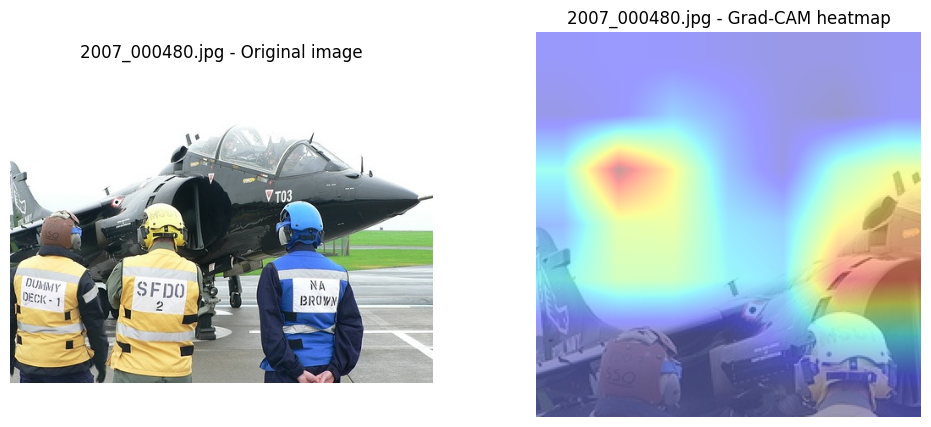

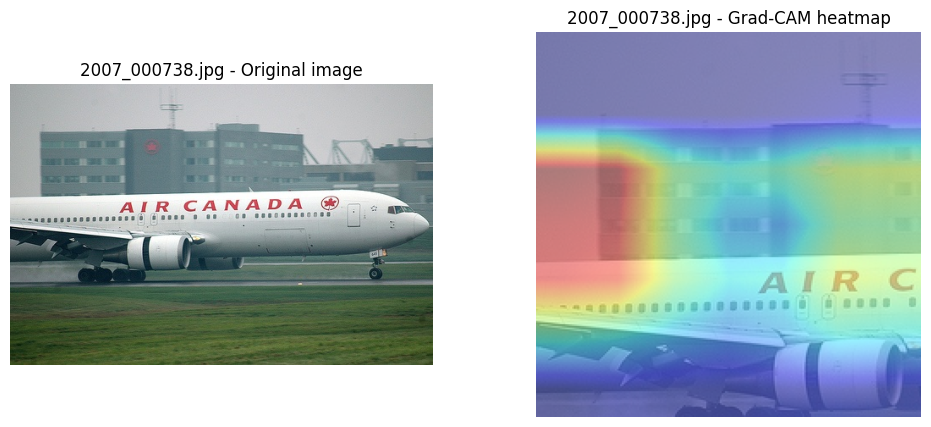

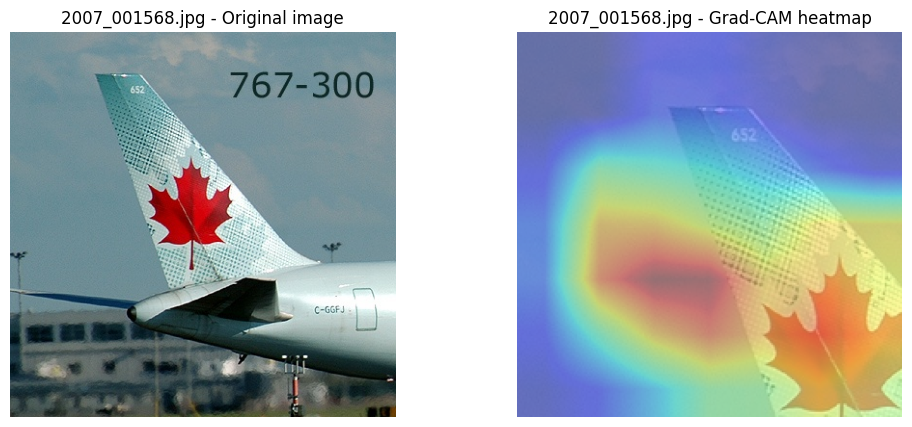

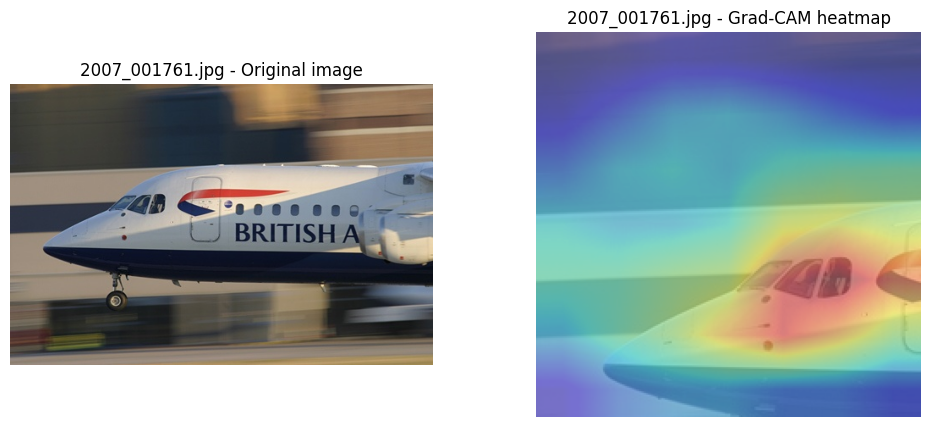

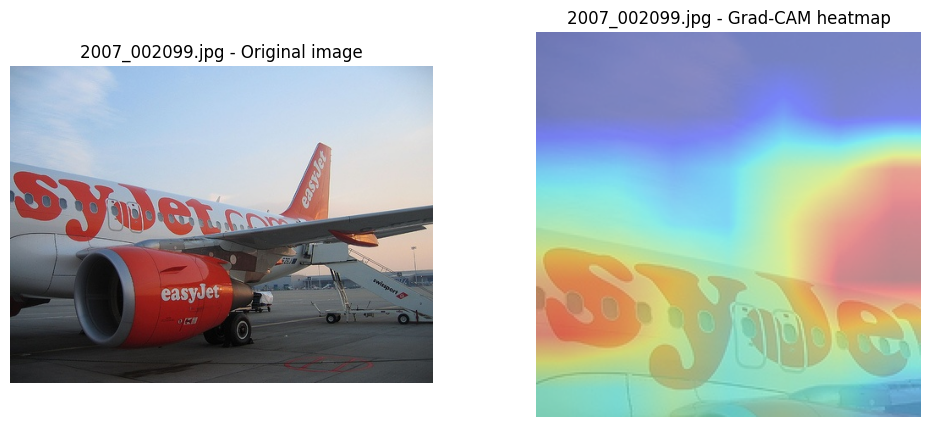

In [9]:
# Set the number of examples to visualize
num_examples = 5
for example in visualization_examples[:num_examples]:
    fname = example['filename']
    original = example['original']
    heatmap = example['heatmap']
    mask = example['mask']

    # Create a figure
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Show the original image on the left subplot
    vis_img = original.copy()
    draw = ImageDraw.Draw(vis_img)
    ax[0].imshow(vis_img)
    ax[0].set_title(f"{fname} - Original image")
    ax[0].axis('off') # refine by chatgpt-4o on 2/5/2025 at 9:00pm

    # Right subplot displays the Grad-CAM heatmap overlaid on the original image
    ax[1].imshow(original, alpha=0.6)
    ax[1].imshow(heatmap, cmap='jet', alpha=0.4)
    ax[1].set_title(f"{fname} - Grad-CAM heatmap")
    ax[1].axis('off')

    plt.show()

* If HO were true, we would expect evenly distributed activation across both foreground and background.
* However, from the Grad-CAM heatmaps, we can see the model primarily focuses on key airplane structures, such as the cockpit, engines, tail, and fuselage, indicating that these areas play an important role in classification.
* Background regions such as the sky, runway, and buildings show lower activation, suggesting that the model does not heavily rely on background cues.
* In some cases, the model pays attention to branding elements like logos, airline names..., which may indicate additional features influencing classification. However, these elements are still part of the airplane, further suggesting that the model focuses on the foreground.

### **Summary: Rejecting H0 & in favor of H1**

✅ Since both the Grad-CAM visualizations and the statistical test show that the model focuses on the airplane rather than the background ( Foreground activations are significantly higher than background activations, both visually and statistically ), we reject **H0** and accept **H1**.

✅ This means the model is correctly learning to classify airplanes based on airplane-related features ( object features ), not background artifacts.
